In [1]:
# https://huggingface.co/docs/transformers/en/tasks/text-to-speech#load-the-dataset
# Transformers installation
! pip3 install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 29.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.7/390.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 39.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.3/411.3 kB 7.8 MB/s eta 0:00:00m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.3 MB/s eta 0:00:00a 0:00:01
 

In [2]:
!pip3 install datasets soundfile speechbrain==0.5.16 accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 7.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 31.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 45.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 52.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 19.1 MB/s eta 0:00:00


In [3]:
!pip3 install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /private/var/folders/sr/6_v8strs3_s6j1q05jw177qh0000gn/T/pip-req-build-7dtgwx5f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/sr/6_v8strs3_s6j1q05jw177qh0000gn/T/pip-req-build-7dtgwx5f
  Resolved https://github.com/huggingface/transformers.git to commit d9850abd407821fb9f4ad5aabb206adad3610f75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.41.0.dev0-py3-none-any.whl size=8998772 sha256=c596123ed15ba97896451193dbe4f5ac5528b4535142830af4ace1013cc8c990
  Stored in directory: /private/var/folders/sr/6_v8strs3_s6j1q05jw177qh0000gn/T/pip-ephem-wheel-cache-b5f3mjmo/wheels/f7/92/8c/752ff3bfcd3439805d8bbf641614da38ef3226e127ebea86ee
Successfully built transformers
  Attemp

In [4]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [9]:
#from huggingface_hub import notebook_login

#notebook_login()

In [1]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "es", split="train")
len(dataset)

/Users/qiaoheqi/anaconda3/envs/dl4m-hw3-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/qiaoheqi/anaconda3/envs/dl4m-hw3-1/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for facebook/voxpopuli contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/facebook/voxpopuli
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


50922

## Import Miya's audio and texts to create datasets

In [31]:
import os
import pandas as pd
import librosa
import numpy as np
from datasets import Dataset, Audio, ClassLabel, Features, Value

# Load the CSV file
csv_file_path = 'SpanishVoiceWav/normalized_text.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)

# Directory containing the WAV files
directory_path = 'SpanishVoiceWav'

# Get a sorted list of all WAV files in the directory
wav_files = sorted([f for f in os.listdir(directory_path) if f.endswith('.wav')])

# Initialize lists for each column
audio_id_list = []
language_list = []
audio_list = []
raw_text_list = []
normalized_text_list = []
gender_list = []
speaker_id_list = []
is_gold_transcript_list = []
accent_list = []

# Define the features schema with ClassLabel for language
features = Features({
    'audio_id': Value(dtype='string'),
    'language': ClassLabel(names=['en', 'de', 'fr', 'es', 'pl', 'it', 'ro', 'hu', 'cs', 'nl', 'fi', 'hr', 'sk', 'sl', 'et', 'lt', 'en_accented']),
    'audio': Audio(sampling_rate=16000),
    'raw_text': Value(dtype='string'),
    'normalized_text': Value(dtype='string'),
    'gender': Value(dtype='string'),
    'speaker_id': Value(dtype='string'),
    'is_gold_transcript': Value(dtype='bool'),
    'accent': Value(dtype='string')
})

# Finding the index for 'es' in the ClassLabel
spanish_index = features['language'].str2int('es')

# Loop through each sorted file in the directory
for idx, filename in enumerate(wav_files):
    file_path = os.path.join(directory_path, filename)
    
    # Load the audio file with librosa
    audio_array, sr = librosa.load(file_path, sr=16000, mono=True)
    
    # Store the audio array in the audio_list
    audio_list.append({'array': audio_array, 'sampling_rate': sr})
    
    # Construct the audio_id to match 't' followed by the index
    audio_id = f't{idx + 1}'  # This will create IDs like 't1', 't2', ..., based on the order in the list
    
    # Get the corresponding normalized_text from the CSV by index
    normalized_text = df.iloc[idx]['normalized_text']  # Assuming order in CSV matches order of sorted filenames
    
    # Append values to corresponding lists
    audio_id_list.append(audio_id)
    language_list.append(spanish_index)  # Use the index for Spanish
    raw_text_list.append(normalized_text)  # Assume raw_text is the same as normalized_text
    normalized_text_list.append(normalized_text)
    gender_list.append('female')
    speaker_id_list.append('9999999')
    is_gold_transcript_list.append(True)
    accent_list.append('None')

# Construct the dictionary and convert to Dataset type
own_dataset_dict = {
    'audio_id': audio_id_list,
    'language': language_list,
    'audio': audio_list,
    'raw_text': raw_text_list,
    'normalized_text': normalized_text_list,
    'gender': gender_list,
    'speaker_id': speaker_id_list,
    'is_gold_transcript': is_gold_transcript_list,
    'accent': accent_list
}

own_dataset = Dataset.from_dict(own_dataset_dict, features=features)

# Print the first example to verify
print(own_dataset[0])


{'audio_id': 't1', 'language': 3, 'audio': {'path': None, 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       6.10351562e-05, 9.15527344e-05, 6.10351562e-05]), 'sampling_rate': 16000}, 'raw_text': 'nuestro equipo encontró una guía muy buena sobre modelos de texto a voz, o tts, en la página de hugging face.', 'normalized_text': 'nuestro equipo encontró una guía muy buena sobre modelos de texto a voz, o tts, en la página de hugging face.', 'gender': 'female', 'speaker_id': '9999999', 'is_gold_transcript': True, 'accent': 'None'}


In [32]:
from datasets import concatenate_datasets

# Assuming own_dataset and dataset are both datasets.arrow_dataset.Dataset objects
combined_dataset = concatenate_datasets([own_dataset, dataset])

## Load and Process data

In [6]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [33]:
#combined_dataset = combined_dataset.cast_column("audio", Audio(sampling_rate=16000))

In [8]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [9]:
tokenizer = processor.tokenizer

In [9]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map: 100%|██████████| 50922/50922 [00:00<00:00, 327643.61 examples/s]


In [ ]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}


vocabs = dataset.map(
    extract_all_chars,
    batched=True,
    batch_size=-1,
    keep_in_memory=True,
    remove_columns=dataset.column_names,
)

dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [34]:
# def extract_all_chars(batch):
#     all_text = " ".join(batch["normalized_text"])
#     vocab = list(set(all_text))
#     return {"vocab": [vocab], "all_text": [all_text]}


# vocabs = combined_dataset.map(
#     extract_all_chars,
#     batched=True,
#     batch_size=-1,
#     keep_in_memory=True,
#     remove_columns=combined_dataset.column_names,
# )

# combined_dataset_vocab = set(vocabs["vocab"][0])
# tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

Map: 100%|██████████| 50938/50938 [00:00<00:00, 406342.99 examples/s]


In [10]:
dataset_vocab - tokenizer_vocab # since we don't have pre-trained tokens for numbers, 
# we just leave 1 as is and it would get converted to <unk>.

{' ', '1', 'á', 'í', 'ñ', 'ó', 'ú', 'ü'}

In [35]:
# For us, Spanish uses the diaeresis (ü), the tilde (ñ), and the acute accent (é, á, í, ó, and ú)
replacements = [
    ("á", "a"),
    ("ñ", "n"),
    ("é", "e"),
    ("ú", "u"),
    ("í", "i"),
    ("ó", "o"),
    ("ü", "u"),
]


def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)
#combined_dataset = combined_dataset.map(cleanup_text)

In [36]:
from collections import defaultdict

speaker_counts = defaultdict(int)

for speaker_id in dataset["speaker_id"]: # or use combined_dataset
    speaker_counts[speaker_id] += 1

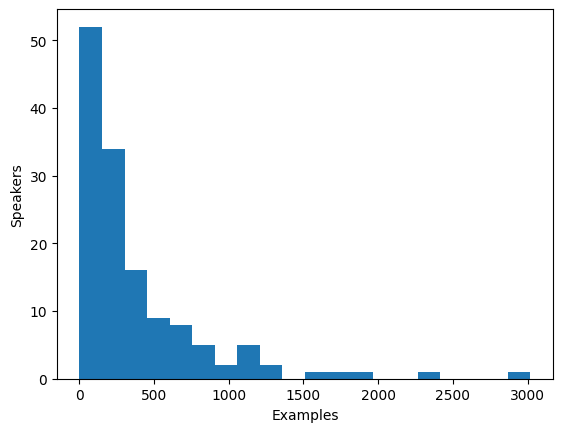

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [14]:
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400


dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter: 100%|██████████| 50938/50938 [00:00<00:00, 842688.95 examples/s]


In [30]:
#speaker_counts['9999999']

16

In [38]:
# def select_speaker(speaker_id):
#     return 16 <= speaker_counts[speaker_id] <= 400


# combined_dataset = combined_dataset.filter(select_speaker, input_columns=["speaker_id"])

Filter: 100%|██████████| 50938/50938 [00:00<00:00, 829893.56 examples/s]


In [39]:
len(set(dataset["speaker_id"]))

88

In [40]:
len(dataset)

14716

In [41]:
import os
import torch
import speechbrain
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

torchvision is not available - cannot save figures


In [42]:
def prepare_dataset(example):
    audio = example["audio"]

    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [19]:
! pip3 install librosa soundfile

In [20]:
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [21]:
processed_example["speaker_embeddings"].shape

(512,)

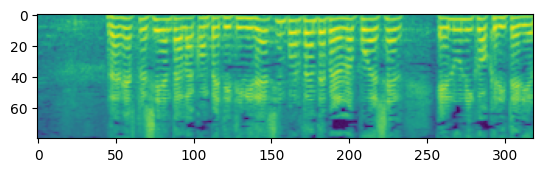

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names)

In [44]:
#combined_dataset = combined_dataset.map(prepare_dataset, remove_columns=combined_dataset.column_names)

Map: 100%|██████████| 14716/14716 [34:50<00:00,  7.04 examples/s]


In [24]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200


dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

Filter: 100%|██████████| 13154/13154 [00:00<00:00, 27965.51 examples/s]


8227

In [25]:
dataset = dataset.train_test_split(test_size=0.1)

In [26]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(input_ids=input_ids, labels=label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100)

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([len(feature["input_values"]) for feature in label_features])
            target_lengths = target_lengths.new(
                [length - length % model.config.reduction_factor for length in target_lengths]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [27]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

## Train the Model

In [31]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [32]:
model.config.use_cache = False

In [33]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_nl",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1449: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

max_steps is given, it will override any value given in num_train_epochs


In [35]:
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1000,0.506000,0.464025
2000,0.485400,0.450527
3000,0.480000,0.447352
4000,0.481400,0.445818


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/si

TrainOutput(global_step=4000, training_loss=0.5087841465473175, metrics={'train_runtime': 8599.3211, 'train_samples_per_second': 14.885, 'train_steps_per_second': 0.465, 'total_flos': 1.8395787548977344e+16, 'train_loss': 0.5087841465473175, 'epoch': 17.28795245813074})

## Load The Model

In [29]:
ls

README.md                        output1.wav
TTS.ipynb                        output2.wav
output.wav                       speecht5_finetuned_voxpopuli_nl/


In [149]:
from transformers import SpeechT5ForTextToSpeech


model_dir = "speecht5_finetuned_voxpopuli_nl"


model = SpeechT5ForTextToSpeech.from_pretrained("speecht5_finetuned_voxpopuli_nl")#.to("cuda:0")


## Inference

In [150]:
#import a vocoder
from transformers import (
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    SpeechT5FeatureExtractor,
    SpeechT5Processor,
)
vocoder = SpeechT5HifiGan.from_pretrained(
        "microsoft/speecht5_hifigan", torch_dtype=torch.float
    )


In [ ]:
# Extract miya's embeddings from one of first 16 rows
example=combined_dataset[1]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [273]:
torch.save(speaker_embeddings, 'SpeakerMiya.pt')

In [269]:
text = "me llamo lixin" #Deeplearning for Media in Spanish

In [270]:
inputs = processor(text=text, return_tensors="pt")

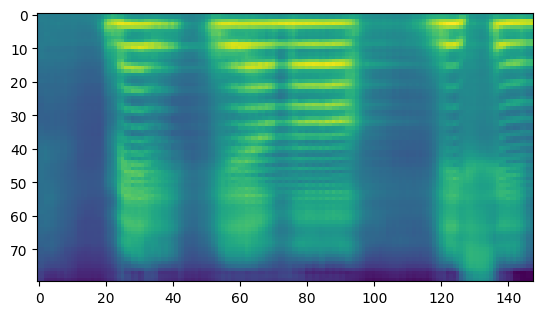

In [271]:
#spectrogram = model.generate_speech(inputs["input_ids"].to("cuda:0"), speaker_embeddings.to("cuda:0"))
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
#spectrogram_cpu = spectrogram.to("cpu")
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

In [272]:
with torch.no_grad():
    
    speech = vocoder(spectrogram)

from IPython.display import Audio

Audio(speech.to("cpu").numpy(), rate=16000)

In [259]:
from scipy.io.wavfile import write
speech_1 = speech.to("cpu").numpy()
fs = 16000
speech_normalized = np.int16(speech_1 / np.max(np.abs(speech_1)) * 32767)

# 写入WAV文件
write('miyavoice_lixindoria.wav', fs, speech_normalized)

In [ ]:
# Original datasets speaker
#example = dataset["test"][777]
#speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)